In [16]:
# blood_demand_model_comparison.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib

c:\Users\USER\miniconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [17]:
# Initialize models with recommended parameters
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        random_state=42
    ),
    "SVM": make_pipeline(
        StandardScaler(),
        SVR(
            C=1.5,
            epsilon=0.1,
            kernel='rbf'
        )
    )
}

In [18]:
def evaluate_models(X, y):
    """Evaluate models using time-series cross-validation"""
    results = {}
    tscv = TimeSeriesSplit(n_splits=3)
    
    for model_name, model in models.items():
        mae_scores = []
        mape_scores = []
        r2_scores = []
        
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            
            mae_scores.append(mean_absolute_error(y_test, preds))
            mape_scores.append(mean_absolute_percentage_error(y_test, preds))
            r2_scores.append(r2_score(y_test, preds))
        
        results[model_name] = {
            'MAE': np.mean(mae_scores),
            'MAPE': np.mean(mape_scores),
            'R2': np.mean(r2_scores),
            'MAE_std': np.std(mae_scores),
            'Model': model
        }
    
    return results

In [19]:
def print_results(results):
    """Display formatted comparison results"""
    print("\nModel Performance Comparison:")
    print("{:<15} {:<10} {:<12} {:<10} {:<12}".format(
        "Model", "MAE", "MAPE (%)", "R2 Score", "MAE Std Dev"))
    print("-" * 60)
    
    for name, metrics in sorted(results.items(), key=lambda x: x[1]['MAE']):
        print("{:<15} {:<10.2f} {:<12.1f} {:<10.2f} {:<12.2f}".format(
            name,
            metrics['MAE'],
            metrics['MAPE']*100,
            metrics['R2'],
            metrics['MAE_std']))


In [20]:
def plot_feature_importance(model, feature_names, title):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features
        
        plt.figure(figsize=(10, 6))
        plt.title(title)
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    elif isinstance(model, Pipeline) and hasattr(model.steps[-1][1], 'feature_importances_'):
        plot_feature_importance(model.steps[-1][1], feature_names, title)


c:\Users\USER\miniconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\Users\USER\miniconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\Users\USER\miniconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



Model Performance Comparison:
Model           MAE        MAPE (%)     R2 Score   MAE Std Dev 
------------------------------------------------------------
Random Forest   8.57       10.3         0.91       0.34        
XGBoost         8.93       10.7         0.91       0.17        
SVM             20.38      25.7         0.57       1.40        


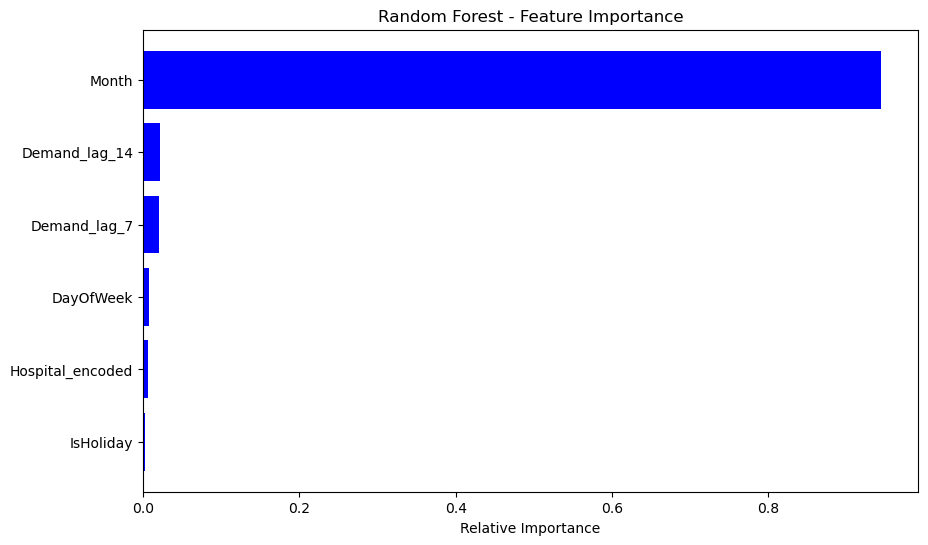

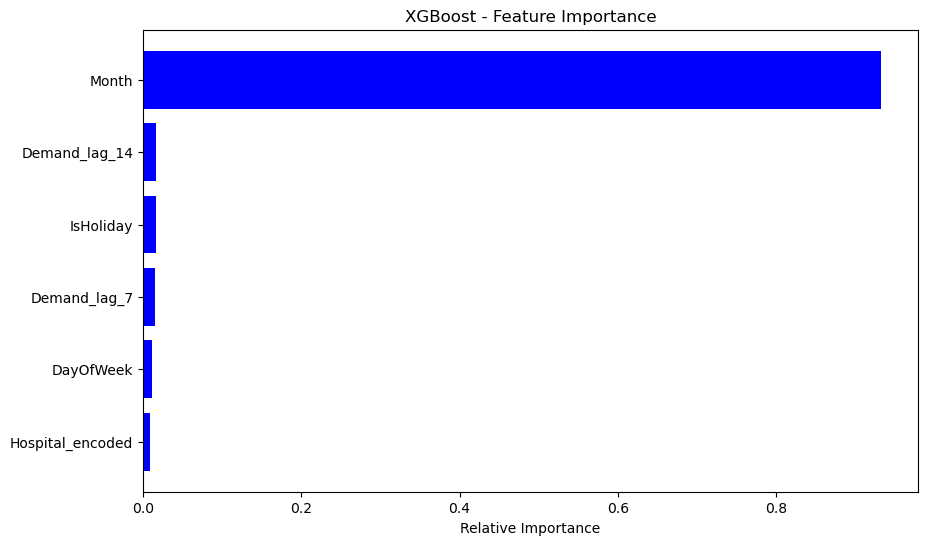

In [22]:
# Example usage
if __name__ == "__main__":
    # Load and preprocess your data
    # df = pd.read_excel("blood_donation_data.xlsx")
    # X = df.drop(columns=['Blood_a', 'Date'])  # Example for Blood Type A
    # y = df['Blood_a']
    
    # For demonstration, we'll create synthetic data
    np.random.seed(42)
    dates = pd.date_range(start='2020-01-01', end='2023-12-31')
    X = pd.DataFrame({
        'Hospital_encoded': np.random.randint(0, 5, len(dates)),
        'Month': [d.month for d in dates],
        'DayOfWeek': [d.weekday() for d in dates],
        'Demand_lag_7': np.random.uniform(50, 150, len(dates)),
        'Demand_lag_14': np.random.uniform(50, 150, len(dates)),
        'IsHoliday': np.random.choice([0, 1], len(dates), p=[0.9, 0.1])
    }, index=dates)
    
    y = pd.Series(
        np.sin(X['Month']/12*2*np.pi) * 50 + 100 + np.random.normal(0, 10, len(dates)),
        index=dates
    )
    
    # Evaluate models
    results = evaluate_models(X, y)
    
    # Print comparison
    print_results(results)
    
    # Visualize feature importance for tree-based models
    for model_name in ['Random Forest', 'XGBoost']:
        plot_feature_importance(
            results[model_name]['Model'],
            X.columns,
            f'{model_name} - Feature Importance'
        )